In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import sys
from sklearn.metrics import fbeta_score
import logging
import numpy as np
from torch.autograd import Variable

## self-inhibtiing neuron model

In [2]:
# Heaviside step function
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = torch.gt(input, 0.)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        x = torch.tanh(input)
        fu = 1.0 - x.mul(x)
        return grad_input * fu

spikeplus = STEFunction.apply

In [3]:
# self-inhibtiing neuron model
class nerve_cell(nn.Module):
    def __init__(self, neuron_num, activation=spikeplus):
        super(nerve_cell, self).__init__()
        self.num = neuron_num
        self._activation = activation
        self._g = nn.LeakyReLU(0.1)

        # define inner weight trainable parameter
        self.weight = nn.Parameter(torch.FloatTensor(self.num, 1))
        self.weight = nn.init.xavier_normal_(self.weight, gain=1)

        # define outer attribute parameter
        self.tau = nn.Parameter(torch.FloatTensor(1))
        self.tau = nn.init.constant_(self.tau, 0.2)

        self.C = nn.Parameter(torch.FloatTensor(1))
        self.C = nn.init.constant_(self.C, 1.0)

        self.gamma = nn.Parameter(torch.FloatTensor(1))
        self.gamma = nn.init.constant_(self.gamma, 0.05)

        self.U_rest = nn.Parameter(torch.FloatTensor(1))
        self.U_rest = nn.init.constant_(self.U_rest, 0.0)

        self.U_th = nn.Parameter(torch.FloatTensor(1))
        self.U_th = nn.init.constant_(self.U_th, -1.0)

        # define the state variable
        self.U = self.U_rest.data.clone().cuda()
        self.s = torch.FloatTensor([0.]).cuda()

    def reset(self):
        self.U = self.U_rest.data.clone().cuda()
        self.s = torch.FloatTensor([0.]).cuda()

    def forward(self, input):
        """
        Inputs:
              input: of shape (batch_size, neuron_num)
        Outputs:
              s: of shape (batch_size, neuron_num)
        """
        # reset
        self.U = torch.mul(self.U, 1.0 - self.s) + torch.mul(self.U_rest, self.s)
        # external stimuli
        I = torch.matmul(input, self.weight)
        # input considering inhibiting-autapse
        I = torch.add(I, - self.gamma.mul(self.s))
        # potential dynamics
        I = torch.mul(I, self.C)
        self.U = torch.mul(self.U, (1.0 - self.tau))  # decay
        self.U = torch.add(self.U, I)
        self.U = torch.add(self.U, torch.mul(self.tau, self.U_rest))
        self.U = self._g(self.U)
        # output
        self.s = self._activation(self.U + self.U_th)

        return self.s


## surrogate neuron

In [4]:
class brain_network(nn.Module):
    def __init__(self, num, criterion = nn.MSELoss()):
        super(brain_network, self).__init__()
        self.n = num
        self.criterion = criterion

        self.layer = nerve_cell(self.n)

    def forward(self, input):
        bs, timesteps, ins = input.size()
        self.layer.reset()
        self.layer.tau.data.clamp_(0.2 - 0.1, 0.2 + 0.1)
        self.layer.C.data.clamp_(1.0 - 0.1, 1.0 + 0.1)
        self.layer.gamma.data.clamp_(0.05 - 0.025, 0.05 + 0.025)
        self.layer.U_rest.data.clamp_(0.0 - 0.5, 0.0 + 0.5)
        self.layer.U_th.data.clamp_(-1.0 - 0.5, -1.0 + 0.5)
        output = 0

        for t in range(timesteps):
            x = self.layer(input[:, t, :])
            output = x
        return output
    
    def loss(self, spiking, target):
        # spiking_rate, [batch_size, output_size]
        #spiking_rate = torch.mean(spiking, dim=1).type(torch.FloatTensor).cuda()
        spiking_rate = spiking.reshape(-1)
        loss = self.criterion(spiking_rate, target)

        prediction = spiking_rate.clone()
        prediction = prediction.cpu().detach().numpy()
        label = target.clone()
        label = label.cpu().detach().numpy()
        macro_f = fbeta_score(label, prediction, average='macro', beta=1)

        return loss, macro_f

In [5]:
neuron = 1 # choose the simulated neuron 
gpu = 0
seed = 0
neuron_num = 28
bs = 32
lr = 0.05
lr_min = 1e-5
wd = 3e-4
epochs = 300
grad_clip = 5
report_freq = 5
data = 'data/'

In [6]:
class AvgrageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt

def train(train_queue, model, optimizer):
    obj_loss = AvgrageMeter()
    obj_ma_f1 = AvgrageMeter()
    
    neurons = [i for i in range(29)]
    neurons.remove(neuron)
    
    model.train()
    for step, (input, target) in enumerate(train_queue):
        n = input.size(0)
        input = input[:, :, neurons]
        target = target[:, neuron]
        input = Variable(input, requires_grad=False).type(torch.FloatTensor).cuda()
        target = Variable(target, requires_grad=False).type(torch.FloatTensor).cuda()

        torch.autograd.set_detect_anomaly(True)
        output = model(input)

        loss, macro_f1= model.loss(output, target)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        optimizer.zero_grad()

        obj_loss.update(loss.item(), n)
        obj_ma_f1.update(macro_f1.item(), n)


        if step % report_freq == 0:
            logging.info('train %03d %e %e', step, obj_loss.avg, obj_ma_f1.avg)
    return obj_loss.avg, obj_ma_f1.avg

def infer(valid_queue, model):
    obj_loss = AvgrageMeter()
    obj_ma_f1 = AvgrageMeter()
    
    neurons = [i for i in range(29)]
    neurons.remove(neuron)
    
    regression = []
    for step, (input, target) in enumerate(valid_queue):
        n = input.size(0)
        input = input[:,:,neurons]
        target = target[:,neuron]
        input = input.type(torch.FloatTensor).cuda()
        target = target.type(torch.FloatTensor).cuda()

        output = model(input)
        loss, macro_f1 = model.loss(output, target)

        out = output.reshape(-1)
        out = out.cpu().detach().numpy()
        regression.extend(out)

        obj_loss.update(loss.item(), n)
        obj_ma_f1.update(macro_f1.item(), n)

    return obj_loss.avg, obj_ma_f1.avg, regression

In [7]:
log_format = '%(asctime)s %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format=log_format, datefmt='%m/%d %I:%M:%S %p')

In [8]:
if not torch.cuda.is_available():
    logging.info('no gpu device available')
    sys.exit(1)
torch.cuda.set_device(gpu)
torch.manual_seed(seed)
cudnn.enabled = True
torch.cuda.manual_seed(seed)
logging.info('gpu device = %s' % gpu)

06/08 11:56:24 PM gpu device = 0


In [9]:
print("load model:")
criterion = nn.MSELoss()
criterion = criterion.cuda()
model = brain_network(num=neuron_num, criterion=criterion).cuda()
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=wd)

load model:


In [10]:
print('load dataset')
x_train = np.load(data + 'x_train.npy')
y_train = np.load(data + 'y_train.npy')
x_test = np.load(data + 'x_test.npy')
y_test = np.load(data + 'y_test.npy')

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

train_data = torch.utils.data.TensorDataset(x_train, y_train)
test_data = torch.utils.data.TensorDataset(x_test, y_test)

print("DataLoader:")
train_queue = torch.utils.data.DataLoader(
    train_data, batch_size=bs,
    pin_memory=True)

test_queue = torch.utils.data.DataLoader(
    test_data, batch_size=100,
    pin_memory=True)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, epochs, eta_min=lr_min)

load dataset
DataLoader:


In [11]:
for epoch in range(epochs):
    lr = scheduler.get_last_lr()[0]
    logging.info('epoch %d lr %e', epoch, lr)
    # training
    train_loss, train_macro_f1= train(train_queue, model, optimizer)
    scheduler.step()
    logging.info('train_loss %f, train_f1 %f',train_loss, train_macro_f1)

06/08 11:56:25 PM epoch 0 lr 5.000000e-02
06/08 11:56:25 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:25 PM train 005 6.250000e-02 6.500787e-01
06/08 11:56:25 PM train_loss 0.090000, train_f1 0.601957
06/08 11:56:25 PM epoch 1 lr 4.999863e-02
06/08 11:56:25 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:26 PM train 005 6.770833e-02 5.654784e-01
06/08 11:56:26 PM train_loss 0.070000, train_f1 0.554819
06/08 11:56:26 PM epoch 2 lr 4.999452e-02
06/08 11:56:26 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:26 PM train 005 5.729167e-02 5.683927e-01
06/08 11:56:26 PM train_loss 0.060000, train_f1 0.575304
06/08 11:56:26 PM epoch 3 lr 4.998767e-02
06/08 11:56:26 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:26 PM train 005 4.687500e-02 6.127902e-01
06/08 11:56:27 PM train_loss 0.060000, train_f1 0.599305
06/08 11:56:27 PM epoch 4 lr 4.997808e-02
06/08 11:56:27 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:27 PM train 005 4.687500e-02 6.127902e-01
06/08 11:56:27 PM trai

06/08 11:56:41 PM train 005 3.125000e-02 7.417989e-01
06/08 11:56:42 PM train_loss 0.033333, train_f1 0.767056
06/08 11:56:42 PM epoch 40 lr 4.783907e-02
06/08 11:56:42 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:42 PM train 005 3.645833e-02 7.792320e-01
06/08 11:56:42 PM train_loss 0.053333, train_f1 0.776701
06/08 11:56:42 PM epoch 41 lr 4.773136e-02
06/08 11:56:42 PM train 000 6.250000e-02 4.838710e-01
06/08 11:56:42 PM train 005 3.645833e-02 7.404335e-01
06/08 11:56:42 PM train_loss 0.030000, train_f1 0.808330
06/08 11:56:42 PM epoch 42 lr 4.762115e-02
06/08 11:56:42 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:43 PM train 005 4.687500e-02 7.430738e-01
06/08 11:56:43 PM train_loss 0.046667, train_f1 0.785617
06/08 11:56:43 PM epoch 43 lr 4.750847e-02
06/08 11:56:43 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:43 PM train 005 4.687500e-02 7.626131e-01
06/08 11:56:43 PM train_loss 0.040000, train_f1 0.786123
06/08 11:56:43 PM epoch 44 lr 4.739332e-02
06/08 11:56:43

06/08 11:56:58 PM epoch 79 lr 4.192351e-02
06/08 11:56:58 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:58 PM train 005 3.125000e-02 8.166622e-01
06/08 11:56:58 PM train_loss 0.030000, train_f1 0.820714
06/08 11:56:58 PM epoch 80 lr 4.172992e-02
06/08 11:56:58 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:58 PM train 005 3.125000e-02 8.055974e-01
06/08 11:56:58 PM train_loss 0.036667, train_f1 0.802964
06/08 11:56:58 PM epoch 81 lr 4.153449e-02
06/08 11:56:58 PM train 000 0.000000e+00 1.000000e+00
06/08 11:56:59 PM train 005 3.645833e-02 7.792320e-01
06/08 11:56:59 PM train_loss 0.046667, train_f1 0.793811
06/08 11:56:59 PM epoch 82 lr 4.133725e-02
06/08 11:56:59 PM train 000 3.125000e-02 4.920635e-01
06/08 11:56:59 PM train 005 3.645833e-02 7.404335e-01
06/08 11:56:59 PM train_loss 0.036667, train_f1 0.763586
06/08 11:56:59 PM epoch 83 lr 4.113821e-02
06/08 11:56:59 PM train 000 3.125000e-02 4.920635e-01
06/08 11:56:59 PM train 005 4.687500e-02 6.820037e-01
06/08 11:57:00 PM

06/08 11:57:14 PM train 005 5.208333e-02 6.946237e-01
06/08 11:57:14 PM train_loss 0.046667, train_f1 0.734267
06/08 11:57:14 PM epoch 119 lr 3.297739e-02
06/08 11:57:14 PM train 000 3.125000e-02 4.920635e-01
06/08 11:57:15 PM train 005 3.645833e-02 6.571429e-01
06/08 11:57:15 PM train_loss 0.046667, train_f1 0.722560
06/08 11:57:15 PM epoch 120 lr 3.272888e-02
06/08 11:57:15 PM train 000 3.125000e-02 4.920635e-01
06/08 11:57:15 PM train 005 3.645833e-02 7.126048e-01
06/08 11:57:15 PM train_loss 0.043333, train_f1 0.755691
06/08 11:57:15 PM epoch 121 lr 3.247952e-02
06/08 11:57:15 PM train 000 3.125000e-02 4.920635e-01
06/08 11:57:15 PM train 005 5.208333e-02 6.668452e-01
06/08 11:57:16 PM train_loss 0.053333, train_f1 0.731382
06/08 11:57:16 PM epoch 122 lr 3.222935e-02
06/08 11:57:16 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:16 PM train 005 2.604167e-02 8.514550e-01
06/08 11:57:16 PM train_loss 0.033333, train_f1 0.855800
06/08 11:57:16 PM epoch 123 lr 3.197838e-02
06/08 11:

06/08 11:57:30 PM train_loss 0.030000, train_f1 0.779851
06/08 11:57:30 PM epoch 158 lr 2.291347e-02
06/08 11:57:30 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:31 PM train 005 3.125000e-02 8.055974e-01
06/08 11:57:31 PM train_loss 0.036667, train_f1 0.825632
06/08 11:57:31 PM epoch 159 lr 2.265276e-02
06/08 11:57:31 PM train 000 3.125000e-02 4.920635e-01
06/08 11:57:31 PM train 005 2.604167e-02 8.208979e-01
06/08 11:57:31 PM train_loss 0.036667, train_f1 0.762625
06/08 11:57:31 PM epoch 160 lr 2.239231e-02
06/08 11:57:31 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:31 PM train 005 4.687500e-02 7.542304e-01
06/08 11:57:32 PM train_loss 0.050000, train_f1 0.777959
06/08 11:57:32 PM epoch 161 lr 2.213215e-02
06/08 11:57:32 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:32 PM train 005 3.645833e-02 8.042320e-01
06/08 11:57:32 PM train_loss 0.040000, train_f1 0.802090
06/08 11:57:32 PM epoch 162 lr 2.187230e-02
06/08 11:57:32 PM train 000 0.000000e+00 1.000000e+00
06/08 11:

06/08 11:57:46 PM epoch 197 lr 1.319359e-02
06/08 11:57:46 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:47 PM train 005 3.125000e-02 8.472662e-01
06/08 11:57:47 PM train_loss 0.036667, train_f1 0.842042
06/08 11:57:47 PM epoch 198 lr 1.296357e-02
06/08 11:57:47 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:47 PM train 005 2.083333e-02 8.667555e-01
06/08 11:57:47 PM train_loss 0.016667, train_f1 0.907828
06/08 11:57:47 PM epoch 199 lr 1.273486e-02
06/08 11:57:47 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:47 PM train 005 2.604167e-02 8.514550e-01
06/08 11:57:48 PM train_loss 0.030000, train_f1 0.816861
06/08 11:57:48 PM epoch 200 lr 1.250750e-02
06/08 11:57:48 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:48 PM train 005 2.083333e-02 9.193974e-01
06/08 11:57:48 PM train_loss 0.023333, train_f1 0.921606
06/08 11:57:48 PM epoch 201 lr 1.228151e-02
06/08 11:57:48 PM train 000 0.000000e+00 1.000000e+00
06/08 11:57:48 PM train 005 3.125000e-02 8.055974e-01
06/08 11:57:

06/08 11:58:02 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:03 PM train 005 4.166667e-02 7.916597e-01
06/08 11:58:03 PM train_loss 0.033333, train_f1 0.841115
06/08 11:58:03 PM epoch 237 lr 5.255075e-03
06/08 11:58:03 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:03 PM train 005 3.125000e-02 8.333759e-01
06/08 11:58:03 PM train_loss 0.033333, train_f1 0.825665
06/08 11:58:03 PM epoch 238 lr 5.095735e-03
06/08 11:58:03 PM train 000 3.125000e-02 4.920635e-01
06/08 11:58:04 PM train 005 3.645833e-02 7.375129e-01
06/08 11:58:04 PM train_loss 0.040000, train_f1 0.763410
06/08 11:58:04 PM epoch 239 lr 4.938577e-03
06/08 11:58:04 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:04 PM train 005 3.645833e-02 8.347442e-01
06/08 11:58:04 PM train_loss 0.036667, train_f1 0.826541
06/08 11:58:04 PM epoch 240 lr 4.783620e-03
06/08 11:58:04 PM train 000 6.250000e-02 4.838710e-01
06/08 11:58:04 PM train 005 5.208333e-02 6.806383e-01
06/08 11:58:05 PM train_loss 0.046667, train_f1 0.760754

06/08 11:58:19 PM train 005 1.041667e-02 9.527770e-01
06/08 11:58:19 PM train_loss 0.010000, train_f1 0.962882
06/08 11:58:19 PM epoch 276 lr 7.952639e-04
06/08 11:58:19 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:19 PM train 005 2.604167e-02 8.347413e-01
06/08 11:58:19 PM train_loss 0.026667, train_f1 0.867722
06/08 11:58:19 PM epoch 277 lr 7.314987e-04
06/08 11:58:19 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:20 PM train 005 1.562500e-02 8.681209e-01
06/08 11:58:20 PM train_loss 0.013333, train_f1 0.908702
06/08 11:58:20 PM epoch 278 lr 6.703953e-04
06/08 11:58:20 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:20 PM train 005 1.041667e-02 9.527770e-01
06/08 11:58:20 PM train_loss 0.010000, train_f1 0.962882
06/08 11:58:20 PM epoch 279 lr 6.119605e-04
06/08 11:58:20 PM train 000 0.000000e+00 1.000000e+00
06/08 11:58:20 PM train 005 1.041667e-02 9.527770e-01
06/08 11:58:21 PM train_loss 0.010000, train_f1 0.962882
06/08 11:58:21 PM epoch 280 lr 5.562007e-04
06/08 11:

In [12]:
with torch.no_grad():
    test_loss, test_macro_f1, array = infer(test_queue, model)
print(test_macro_f1)

0.7582764056752496


## Visualization

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

06/08 11:58:29 PM NumExpr defaulting to 8 threads.


### Heatmap

In [14]:
GT = np.load(data + 'neuron2_y_test.npy')
GT = GT[:, np.newaxis]
Ours = np.array(array)
Ours = Ours[:, np.newaxis]
spike_train = np.concatenate((GT, Ours),axis=1).T

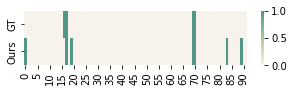

In [15]:
plt.figure(figsize=(5,1))
ax = sns.heatmap(spike_train,
                 cmap = sns.cubehelix_palette(dark=0.5, light=0.95, as_cmap=True, start= 3.5, rot=-.8),
                 yticklabels = ['GT', 'Ours'])
plt.show()

### Confusion Matrix

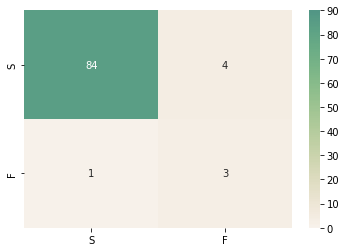

In [16]:
Ours_confusion = confusion_matrix(spike_train[0, :], spike_train[1, :])
ax = sns.heatmap(Ours_confusion, annot=True,
                 cmap = sns.cubehelix_palette(dark=0.5, light=0.95, as_cmap=True, start= 3.5, rot=-.8),
                 vmin=0, vmax=90,
                 xticklabels = ['S', 'F'], yticklabels = ['S', 'F'])
                 
plt.show()